Notebook 8: Deep Neural Networks (DNNs)
=======================================

## Goals for learning
In this assignment, we will:
1) Introduce the **[PyTorch](https://pytorch.org/)** and TorchVision libraries for working with deep neural networks.
2) Practice **image classification** with deep neural netowrks.

## Instructions
* Read through the notebook.
* Answer any plain text questions (replace cell content, "YOUR RESPONSE HERE", with your response).
* Insert your code within the code blocks marked with the comments "# START your code here" and "# STOP your code here".
* Do not use loops, iteration, or recursion in any of the code cells (except where explicitly allowed).
* When transforming collections of items in the same manner, do not simply copy/paste with an index into each item. Instead, you should be using array operations.
* Do not use any "Generative AI" tools or assistants in the creation of your solutions.
* Do not import or use any libraries other than those already imported outside the "# START your code here" and "# STOP your code here" blocks.
    * In some blocks, you are not allowed to use certain numpy and pandas methods. Please pay attention to the "TO DO" instructions.
* Run all cells to make sure your code works and you see reasonable results.
    * All code cells should have output indicating the results of the last run when the notebook is submitted.
    * If there are errors, or if a code cell does not have output as submittted, points will be deducted.

## Submission details
* Due: Monday 11/10, 11:59 PM
* [Submission instructions](https://www.cs.oswego.edu/~agraci2/csc461/submission_instructions.html)

## Background
Previously in NB7, we implemented a neuron from scratch to better gain intuitions about the underlying mechanics of how basic neural networks operate. In this project, we will be working with libraries that enable us to operate at a higher level of abstraction but try to keep in mind what is going on under the hood!

## Notebook Premise
You are working for a software company that is developing an app that digitizes handwritten ledgers. You are tasked with implementing an **image classifier** to recognize handwritten digits, using a **neural network**.

## About the data set
The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a large set of handwritten digits (labeled 0-9), formatted as 28x28 pixel grayscale images. 

Although the database is available for download in binary format from [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/), we will be using the TorchVision API to retrieve and load the data for us in this notebook.

## Python library dependencies
* [Pytorch](https://pytorch.org/) - "PyTorch is an optimized tensor library for deep learning using GPUs and CPUs." 
* [TorchVision](https://pytorch.org/vision/stable/index.html) - "The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision."

## Preparing the Data

### Loading data with TorchVision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Set the seed for random calls to enhance reproducibility
torch.manual_seed(42)

# Data will be cached down one directory from where you are currently working. The data should not be included in your assignment submission.
DOWNLOAD_DATA=True
MNIST_DOWNLOAD_ROOT='./mnist_torch/'

In [2]:
# Utility function to load the MNIST dataset. Returns a training data set and an evaluation data set.
def LoadDataMNIST(normalize=True, base_path=MNIST_DOWNLOAD_ROOT, download=True):

    # Modify the output path for normalized data
    if normalize:
        base_path = base_path + "norm"
    else:
        base_path = base_path + "nonorm"

    # Define transformations to apply to the data
    transformation_list = []
    transformation_list.append(transforms.ToTensor()) # Convert to "tensor"
    if normalize:
        transformation_list.append(transforms.Normalize((0.5,), (0.5,))) # Normalize the data
    transform = transforms.Compose(transformation_list)

    # Load (or download) our training and test datasets
    train_data = torchvision.datasets.MNIST(
        root=base_path, 
        train=True,
        download=download, 
        transform=transform)
    
    # Load (or download) our training and test datasets
    eval_data = torchvision.datasets.MNIST(
        root=base_path, 
        train=False,
        download=download, 
        transform=transform)
    
    return train_data, eval_data

In [3]:
# Download the training and evaluation dataset
train_data, eval_data = LoadDataMNIST(normalize=True, base_path=MNIST_DOWNLOAD_ROOT, download=True)

Now that **TorchVision** handled **downloading** and **transforming** our data for us, we can use **PyTorch** to **batch** and **shuffle** our data for us using the [DataLoader](https://docs.pytorch.org/docs/stable/data.html) interface.

When we go to train our model with the Gradient Descent algorithm, the batch size will determine which type of gradient descent we are performing:
* Batch size of 1: "Stochastic" gradient descent
* Batchsize > 1 but < the size of the dataset: "Mini-batch" gradient descent
* Batch size equals the size of the dataset: "Batch" gradient descent

In [4]:
BATCH_SIZE = 32 # Number of image samples to look at per training iteration 

In [5]:
# Utility function to greate a data loader for the training set and the evaluation set
def GetDataLoaders(train_data, eval_data, batch_size_train, batch_size_eval):
    
    train_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size=batch_size_train,
        shuffle=True)
    
    eval_loader = torch.utils.data.DataLoader(
        eval_data, 
        batch_size=batch_size_eval,
        shuffle=False)
    
    return train_loader, eval_loader

In [6]:
train_loader, eval_loader = GetDataLoaders(train_data, eval_data, batch_size_train=BATCH_SIZE, batch_size_eval=BATCH_SIZE)

##### <b>Question:</b> Based on our batch size, what type of gradient descent will we be performing?

In [7]:
# Emma test
print(len(eval_data))

10000


##### <b>Question:</b> Why do we need to shuffle our training data?

##### <b>Question:</b> Why don't we need to shuffle our evaluation data?

### Working with "Tensors"
In PyTorch, a [**tensor**](https://pytorch.org/docs/stable/tensors.html) is a data type that represents a multi-dimensional array, much like the NumPy N-dimensional array and Pandas Dataframe types that we have been using so far. 

PyTorch tensors have a couple of extra features that are of particular interest to us in this Deep Learning project:

1) Tensors provide support for [**automatic differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation), which calculates the derivatives we need for training our network.
    * In previous notebooks, we implemented intuitive variants of the gradient descent algorithm to minimize our cost funtions.
    * More commonly, derivatives are used to determine the direction and step size used to modify weights and biases.
2) Tensors provide support for running on [CPUs](https://en.wikipedia.org/wiki/Central_processing_unit) or [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) (if available).
    * Unfortunately, our current environment does not have access to GPU resources that we can leverage to speed up the training and evaluation process of our networks.
    * I encourage you to make use of this feature if you have a computer with a GPU available to you.

In [8]:
# Get a batch of images from the training dataset
batch_iter = iter(train_loader)
batch_images, batch_labels = next(batch_iter)

# Print out a few statistics about our data
print("Training data type: {}".format(type(batch_images)))
print("Training data shape: {}".format(batch_images.shape))
print("Training data device: {}".format(batch_images.device))

'''
TO DO: As needed, play around with the tensor objects to get to know them
'''
# START your code here

# STOP your code here

# Check which devices are available, and cache the best one
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU.")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU.")

Training data type: <class 'torch.Tensor'>
Training data shape: torch.Size([32, 1, 28, 28])
Training data device: cpu
Using CPU.


### Displaying input data with Matplotlib

In the cell below, there is a utility function to display a configurable number of MNIST sample images.

<u>Example usage</u>:
```python
DisplayImagesMNIST(image_data)
```

There is also a utility function to summarize some information about your input dataset as well as display some sample images.

<u>Example usage</u>:
```python
SummarizeDatasetMNIST(data_loader)

In [9]:
import matplotlib.pyplot as plt

# Define a function to render a subset of images
def DisplayImagesMNIST(image_data, num_to_show=5):
    for idx in range(num_to_show):
        
        # Create a 1x5 plot of images (index from 1)
        ax = plt.subplot(1, 5, idx+1)
    
        # Reshape from (1,28,28) to (28,28)
        plt.imshow(image_data[idx].reshape(28, 28), cmap="gray_r")
        plt.xticks([]) # Don't show x-axis ticks
        plt.yticks([]) # Don't show x-axis ticks
        
    plt.show()

# Display some statistics about the dataset as well as a subset of images
def SummarizeDatasetMNIST(data_loader, num_to_show=5):
    # Get a batch of images from the training dataset
    batch_iter = iter(data_loader)
    batch_images, batch_labels = next(batch_iter)

    # Print out a few statistics about our data
    print("Image data type: {}".format(type(batch_images)))
    print("Image shape: {}".format(batch_images.shape))
    print("Image processing device: {}".format(batch_images.device))
    print("Number of images: {}".format(len(data_loader.dataset)))
    print("Number of batches: {}".format(len(data_loader)))

    # Render a subset of the images, along with their known labels
    num_to_show = num_to_show if num_to_show < batch_images.shape[0] else batch_images.shape[0]
    print(batch_labels[:num_to_show])
    DisplayImagesMNIST(batch_images, num_to_show)

Image data type: <class 'torch.Tensor'>
Image shape: torch.Size([32, 1, 28, 28])
Image processing device: cpu
Number of images: 60000
Number of batches: 1875
tensor([9, 9, 4, 7, 7])


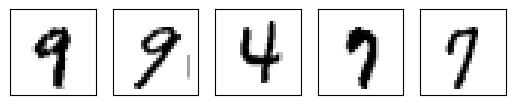

Image data type: <class 'torch.Tensor'>
Image shape: torch.Size([32, 1, 28, 28])
Image processing device: cpu
Number of images: 10000
Number of batches: 313
tensor([7, 2, 1, 0, 4])


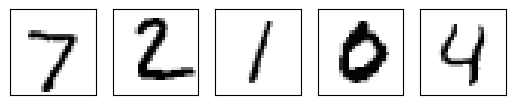

In [16]:
SummarizeDatasetMNIST(train_loader)
SummarizeDatasetMNIST(eval_loader)

## Simple Classifier Model

### Defining the model inputs and outputs
* The inputs of this classifier model will be the MNIST image samples that we loaded.
* The outputs of this classifier will be predictions for each possible label.
    * Note: This is a multi-class problem. Consider how many possible labels there are.

### Defining the model structure
In the call below, we will define our **neural network** model as a class called "ClassifierNet".

Using the PyTorch framework, neural network models are **subclasses** of the [**Module**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class.

> PyTorch uses modules to represent neural networks. Modules are:
>
> * Building blocks of stateful computation. PyTorch provides a robust library of modules and makes it simple to define new custom modules, allowing for easy construction of elaborate, multi-layer neural networks.
> * Tightly integrated with PyTorch’s autograd system. Modules make it simple to specify learnable parameters for PyTorch’s Optimizers to update.
> * Easy to work with and transform. Modules are straightforward to save and restore, transfer between CPU / GPU / TPU devices, prune, quantize, and more.
>
> From the [PyTorch v 2.1 Documentation](https://pytorch.org/docs/stable/notes/modules.html)

Implement the model below woth the following architecture:

1) A linear (see: [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) **hidden layer** with 4 neurons that uses the ReLU (see: [F.relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html)) activation function (values between 0 and infinity).
3) Another linear **hidden layer** with 8 neurons that uses the ReLU activation function (values between 0 and infinity).
4) A linear **output layer** with "OUTPUT_SIZE" neurons that uses the Tanh (see: [F.tahn](https://pytorch.org/docs/stable/generated/torch.nn.functional.tanh.html#torch.nn.functional.tanh)) activation function (continuous values between 0 and 1).

In [12]:
import torch.nn as nn
import torch.nn.functional as F

'''
TO DO: Define the size of the input to the neural network and the size of the output from the neural network.
Hint: Review your lecture notes. What determines the size of the inputs and the size of the outputs?
'''
# START your code here
INPUT_SIZE = 784        # MNIST 28 * 28 pixels
OUTPUT_SIZE = 10        # 10 possible digit classes (0–9)
# STOP your code here


# Define the structure of the neural network
class ClassifierNet(nn.Module):
    
    # Constructor
    def __init__(self):
        super().__init__()

        self.L1 = None # First hidden layer
        self.L2 = None # Second hidden layer
        self.LN = None # Output layer
        
        '''
        TO DO: Instantiate the layers (L1-LN) according to the above description
        '''
        # START your code here
        self.L1 = nn.Linear(INPUT_SIZE, 4)
        self.L2 = nn.Linear(4, 8)
        self.LN = nn.Linear(8, OUTPUT_SIZE)
        # STOP your code here

    # Defines the steps taken during the "forward pass"
    def forward(self, input):
        
        # Get the input data into a shape we can work with (remove the "channel" axis of size "1")
        data = input.view(input.size(0), INPUT_SIZE)

        '''
        TO DO: 
         - The input layer is  provided above
         - Pass the data through the hidden and output layers, along with their respective activation functions as defined above
        '''
        # START your code here
        data = F.relu(self.L1(data))
        data = F.relu(self.L2(data))
        data = F.tanh(self.LN(data))
        # STOP your code here
        
        return data

### Training the model
In our previous notebook (NB7) we trained our neuron by minimizing an error function using a version of the gradient descent algorithm.

We do something similar below:

1) For our **error function**, we use [cross entropy loss](https://en.wikipedia.org/wiki/Cross-entropy), which is well-suited to classification problems.
   * Different error functions work better for different problems. For example, MSE is often used for regression problems. 
2) We let an [**optimizer**](https://pytorch.org/docs/stable/optim.html) calculate our derivitives for us (this indicates a direction and amount to move our weights and biases).
   * There are different algorithms we could choose from, but here we stick with gradient descent [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).
   * Note: Although this optimizer class is named "SGD" for "stochastic gradient descent", it is possible to perform stochastic, mini-batch, or batch gradient descent, depending on your DataLoader.

Training a model often takes a long time. For large networks it could take **hours** or **days**. For the default values of our model, training took under a minute for me. When you increase the number of neurons in each layer, add layers to the model, or change any hyperparameters, make sure to do so incrementally, and note the changes that it makes in terms of training time.

<u>Implementation hints:</u>
* Read the documentation for your optimizer. See: [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
    * Pay special attention to the "zero_grad" and "step" functions.
* Read the documentation for your error function. See: [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
    * Pay special attention to the "backward" function.

In [13]:
# Train a model using the provided training data
def TrainModel(train_loader, classifier_net):
    
    # Hyperparameters used for training
    EPOCHS = len(train_loader) * 2
    LEARNING_RATE = 0.0001
    MOMENTUM = 0.99
    
    '''
    TO DO: 
     - Specify the algorithm to use for minimizing the error
     - Specify the error function we will be minimizing
    '''
    # START your code here
    optimizer = torch.optim.SGD(classifier_net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    error_function = nn.CrossEntropyLoss()
    # STOP your code here

    # Each epoch we will iterate over a random batch of the training data
    batch_iter = iter(train_loader)
    
    print("Started training...")

    # Train the model iteratively, over a configurable number of epochs
    for epoch in range(EPOCHS):

        # If we run through all the batches, reset the iterator
        if (epoch % len(train_loader)) == 0:
            batch_iter = iter(train_loader)
            
        # Get the next "random" batch. ach batch consists of inputs (feature vectors) and the known labels for each data item.
        inputs, labels = next(batch_iter)

        '''
        NOTE:
         - Here is where we start letting the optimizer calculate our derivitives for us!
        TO DO: 
         - Use your optimizer to zero-out the gradients for the weights and biases. Otherwise they would accumulate over each batch.
         - Run the "forward pass" through your model
             - Data goes from Input Layer -> Hidden Layer 1 -> ... -> Hidden Layer N -> Output Layer
         - Compute the error using your error function (defined above)
         - Using your error function result, run the "backpropagation" or "backwards pass" through the model
            - Error goes from Output Layer -> Hidden Layer N -> ... -> Hidden Layer 1 -> Input Layer
        - Using your optimizer, Update the weights and biases
        '''
        # START your code here
        optimizer.zero_grad()                 # 1 - optimizer
        outputs = classifier_net(inputs)      # 2 - forward pass
        loss = error_function(outputs, labels) # 3 - error
        loss.backward()                       # 4 - backpropagation
        optimizer.step()                      # 5 - update weights and biases
        # STOP your code here

    print('Finished Training.')

In [14]:
%%time
# ^This will display how long it takes to execute this cell

# Instantiate the neural network model to train
classifier_net = ClassifierNet() 

# Train the model
TrainModel(train_loader, classifier_net)

Started training...
Finished Training.
CPU times: total: 4min 27s
Wall time: 1min 20s


### Evaluating the model

In [15]:
# Evaluate a single batch and visualize the prediced vs true labels
def VisualizeSingleBatchEvaluation(eval_loader, model):
    # Get a batch of data for evaluation/testing (not in the training data)
    eval_iter = iter(eval_loader)
    batch_images, batch_labels = next(eval_iter)

    # Run a batch of evaluation data through the trained model
    outputs = model(batch_images)
    _, predicted = torch.max(outputs, 1)

    # Show some sample true vs predicted labels, as well as the corresponding images
    NUM_IMAGES_TO_SHOW = 5
    print("Truth:     {}".format(str(batch_labels[:NUM_IMAGES_TO_SHOW])))
    print("Predicted: {}".format(str(predicted[:NUM_IMAGES_TO_SHOW])))
    DisplayImagesMNIST(batch_images, NUM_IMAGES_TO_SHOW)

Truth:     tensor([7, 2, 1, 0, 4])
Predicted: tensor([9, 2, 3, 6, 9])


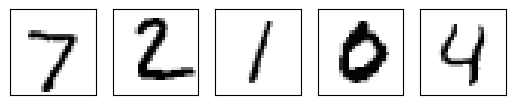

In [16]:
VisualizeSingleBatchEvaluation(eval_loader, classifier_net)

In [17]:
# Calculate the accuracy of a model using the provided evaluation data
def CalculateAccuracy(eval_loader, model):
    # Store the number of correct predictions and total predictions
    correct = 0
    total = 0

    # Since we're not training, we don't need to calculate the gradients
    with torch.no_grad():
        for data in eval_loader:
            images, labels = data
        
            # Run the images through the network
            outputs = model(images)
        
            # Predict the labels with the highest probability
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [18]:
%%time
# ^This will display how long it takes to execute this cell

accuracy = CalculateAccuracy(eval_loader, classifier_net)
print('Accuracy accross labels: {}'.format(accuracy))

Accuracy accross labels: 38.59
CPU times: total: 17.9 s
Wall time: 6.01 s


## Creating a Better Model

### Defining the new model
Experiment with different neural network architectures to achieve better results.

A few ideas of things to try include:
* Stick with linear layers but try different:
    * Numbers of hidden layers
    * Number of nodes within the layers
    * Activation functions
* Try different types of layers, such as:
    * Convolution layers, see: [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
    * Pooling layers, see: [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

In [19]:
# Define the structure of the neural netowrk
class BetterClassifierNet(nn.Module):
    
    # Constructor
    def __init__(self):
        super().__init__()

        '''
        TO DO: Instantiate any layers you need
        '''
        # START your code here
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)     # layer 1
        self.pool = nn.MaxPool2d(2, 2)                       # pool layer
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)    # layer 2
        self.fc1 = nn.Linear(16 * 7 * 7, 64)                 # connected layer
        self.fc2 = nn.Linear(64, 10)                   # output layer
        # STOP your code here

    # Defines the steps taken during the "forward pass"
    def forward(self, input):
        '''
        TO DO: 
         - Perform any reshaping operations you need to perform on the data
         - Pass the data through each of your layers and their respective activation functions
        '''
        # START your code here
        data = F.relu(self.conv1(input))     # conv1 + ReLU
        data = self.pool(data)               # pooling
        data = F.relu(self.conv2(data))      # conv2 + ReLU
        data = self.pool(data)               # pooling again
        data = data.view(-1, 16 * 7 * 7)     # 4D tensor ---> 2D (batch_size, features)
        data = F.relu(self.fc1(data))        # fully connected + ReLU
        data = F.tanh(self.fc2(data))        # output layer + tanh
        # STOP your code here
        
        return data

### Training the model
Re-use the same training function you defined before.

In [20]:
%%time
# ^This will display how long it takes to execute this cell

# Instantiate the neural network model to train
better_classifier_net = BetterClassifierNet() 

# Train the model
TrainModel(train_loader, better_classifier_net)

Started training...
Finished Training.
CPU times: total: 5min 36s
Wall time: 2min 19s


### Evaluating the model
Evaluate the model by re-using the evaluation functions defined above.

Truth:     tensor([7, 2, 1, 0, 4])
Predicted: tensor([7, 2, 1, 0, 4])


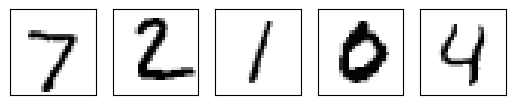

In [21]:
VisualizeSingleBatchEvaluation(eval_loader, better_classifier_net)

In [22]:
%%time
# ^This will display how long it takes to execute this cell

accuracy = CalculateAccuracy(eval_loader, better_classifier_net)
print('Accuracy accross labels: {}'.format(accuracy))

Accuracy accross labels: 92.94
CPU times: total: 15.9 s
Wall time: 5.47 s


### Checkpoint for accuracy
Use the checkpoint below to determine if your "Better" classification model is performing well enough.

In [23]:
# Adding a checkpoint for improving the model's accuracy
TARGET_ACCURACY = 90
assert accuracy > TARGET_ACCURACY, "Try to improve the model's accuracy. Current accuracy: {}".format(accuracy)
print("Passed checkpoint.")

Passed checkpoint.


Congratulations, you have reached the end of this notebook!